In [1]:
import numpy as np
import pandas as pd
import cv2
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow import keras
from sklearn import metrics

import random

2024-05-16 09:36:57.748584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 09:36:57.748710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 09:36:57.884541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base path
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data' #Chemin jusqu'aux dossiers Test Train Val
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [3]:
# Only run this cell if working files are not in kaggle working directory
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

100%|██████████| 2/2 [00:40<00:00, 20.01s/it]


In [4]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


In [5]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.keras.applications.xception import preprocess_input # Preprocess for XCeption model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    '''This function normalizes images by equalizing histograms (grayscale only)'''
    
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed


# Instanciation of image data generators using the preprocessing function defined before

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image) 
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [7]:
# Preprocessing of each folder

batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                        classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                         classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)

nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


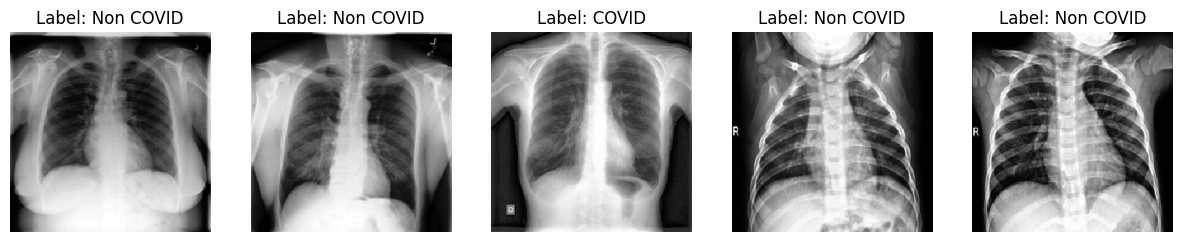

In [25]:
# Visual check of images in generators:

class_names = {
    0: 'COVID',
    1: 'Non COVID',
    2: 'Normal'
}
# Function to visualize images from a batch
def visualize_images(image_batch, label_batch, num_images=5):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        # Modify the image to have a good contrast as the preprocess_input is not compatible with the default values of plt.imshow
        contrasted_image = (image_batch[i]+1)*127.5
        contrasted_image = keras.utils.array_to_img(contrasted_image)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(contrasted_image)
        plt.title(f"Label: {class_names[label_batch[i]]}")
        plt.axis('off')
    plt.show()

# Retrieve a batch of images and labels from the generator
train_generator.reset()
batch_images, batch_labels = train_generator[1]

# Visualize the batch of images
visualize_images(batch_images, batch_labels)

Same processing with masked images

In [9]:
def application_masks(image,mask):
    '''Cette fonction prend une image et applique le masque correspondant pour ne faire ressortir que les poumons'''
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
        
masks_applicated = "masks_applicated"
        
for sett in sets:
    for group in groups:
        ima_dir = os.path.join(base_path, sett, group, "images")
        mask_dir = os.path.join(base_path, sett, group, "lung masks")
    
        masks_applicated_path = os.path.join(destination_path, sett, group, masks_applicated)
    
        if not os.path.exists(masks_applicated_path):
            os.mkdir(masks_applicated_path) # Création du nouveau dossier pour stocker la combinaison si il n'existe pas déjà
        else :
            print("Le dossier existe déjà")
        
        for image in tqdm(os.listdir(ima_dir)):
            image_path = os.path.join(ima_dir, image) # Chemin de l'image
            image_read = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask_path = os.path.join(mask_dir, image) # Chemin du mask qui porte le même nom que l'image
            mask_read = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            result_image = application_masks(image_read, mask_read) # On applique le mask sur l'image
            result_image_path = os.path.join(destination_path, sett, group, masks_applicated, image) # On récupère le chemin de l'image dans le dossier
        
            cv2.imwrite(result_image_path, result_image) # On met l'image dans le nouveau dossier

100%|██████████| 7208/7208 [01:29<00:00, 80.71it/s]


In [10]:
# Moving masks for the "flow_from_directory"

mask_destination_path = '/kaggle/working/COVID-EX-Qu-dataset-mask'

for sett in sets:
    for group in groups:
        ima_dir = os.path.join(destination_path, sett, group)
        for dos in tqdm(os.listdir(ima_dir)):
            if dos=="masks_applicated":
                shutil.move(os.path.join(destination_path, sett, group, dos), os.path.join(mask_destination_path, sett, group, dos))

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


In [11]:
# Preprocessing of each "mask" folder

train_generator_mask = train_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Train'),
                                                           classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator_mask = test_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Val'),
                                                        classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator_mask = test_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Test'),
                                                         classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)

nb_img_train_mask = train_generator_mask.samples
nb_img_val_mask = val_generator_mask.samples

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


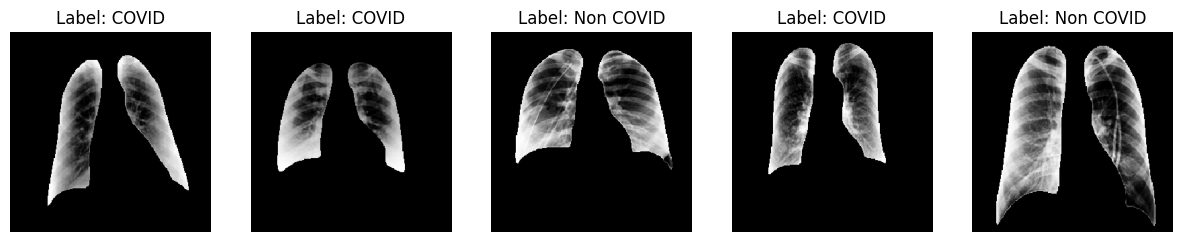

In [26]:
# Visual check of masked_images in generators:

# Retrieve a batch of images and labels from the mask generator
train_generator_mask.reset()
batch_masked_images, batch_masked_labels = train_generator_mask[1]

# Visualize the batch of images
visualize_images(batch_masked_images, batch_masked_labels)

Implementing models

In [13]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[36:]:
        layer.trainable = True

    # Add custom classifier layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [14]:
XCeption_callbacks = build_model()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

In [16]:
# Model training - No early stopping as the fluctuation of val_loss is messing with it
history_Xception_callbacks = XCeption_callbacks.fit(train_generator, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size,
                                callbacks = [reduce_learning_rate]
                                )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715852912.485510     157 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715852912.548685     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8074 - loss: 0.4910

W0000 00:00:1715853144.030338     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 306s 374ms/step - accuracy: 0.8075 - loss: 0.4908 - val_accuracy: 0.8634 - val_loss: 0.3521 - learning_rate: 0.0010
Epoch 2/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 3:17 292ms/step - accuracy: 0.9062 - loss: 0.2215

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9062 - loss: 0.2215 - val_accuracy: 0.7778 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 328ms/step - accuracy: 0.9176 - loss: 0.2330 - val_accuracy: 0.8358 - val_loss: 0.7330 - learning_rate: 0.0010
Epoch 4/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 3:21 297ms/step - accuracy: 0.9375 - loss: 0.2049
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - accuracy: 0.9375 - loss: 0.2049 - val_accuracy: 0.8889 - val_loss: 0.6540 - learning_rate: 0.0010
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 328ms/step - accuracy: 0.9423 - loss: 0.1589 - val_accuracy: 0.9493 - val_loss: 0.1386 - learning_rate: 1.0000e-04
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9688 - loss: 0.1115 - val_accuracy: 1.0000 - val_loss: 0.0257 - learning_rate: 1.0000e-04
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 328ms/step - accuracy: 0.9582 - 

In [17]:
evaluation_callbacks = XCeption_callbacks.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_callbacks[0])
print("Test Accuracy:", evaluation_callbacks[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.9706 - loss: 0.1059
Test Loss: 0.14954477548599243
Test Accuracy: 0.9596346616744995


  2/213 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step

W0000 00:00:1715855222.718664     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2395
           1       0.95      0.93      0.94      2140
           2       0.93      0.96      0.95      2253

    accuracy                           0.96      6788
   macro avg       0.96      0.96      0.96      6788
weighted avg       0.96      0.96      0.96      6788



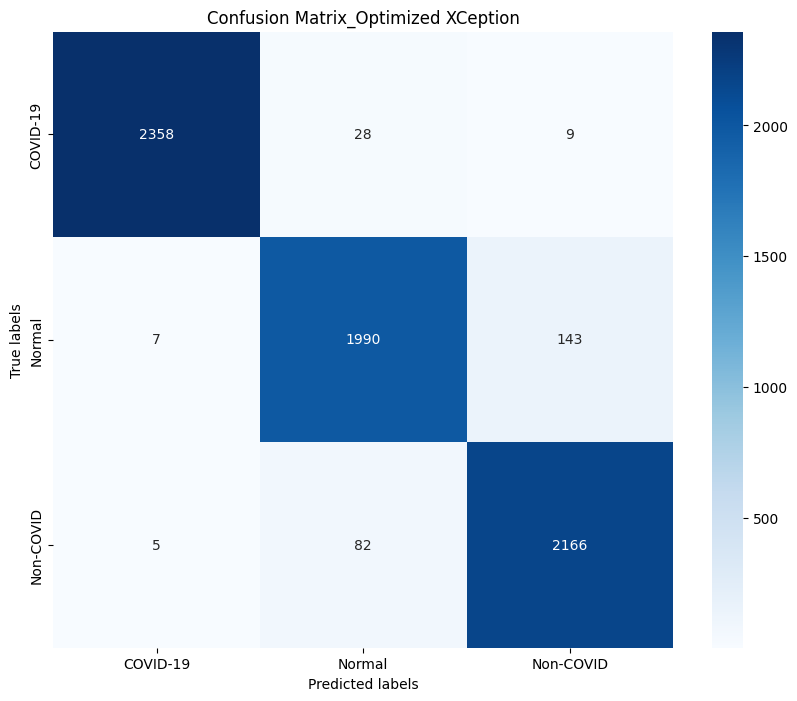

In [18]:
# Confusion_ matrix:

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions on the test data
predictions = XCeption_callbacks.predict(test_generator)
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
# Get the true classes
true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(classification_report(true_classes, predicted_classes))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix_Optimized XCeption')
plt.show()

In [21]:
# Visualization of results on images from test_generator data:
class_names = {
    0: 'COVID',
    1: 'Non COVID',
    2: 'Normal'
}

# Function to apply the model on a batch of images and visualize the results
def apply_model_and_visualize_multiple_images(model, data_generator, num_images=12):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        # Retrieve one image and its label from the generatorl 
        batch_images, batch_labels = random.choice(data_generator)
        image = batch_images[0]  # Take the first image from the batch
        label = round(batch_labels[0])  # Corresponding label
        
        # Reshape the image to (1, height, width, channels) for model prediction
        image = np.expand_dims(image, axis=0)
        
        # Apply the trained model to obtain prediction
        prediction = model.predict(image)
        
        # Round the predicted label to the nearest integer
        predicted_label = np.argmax(prediction)
        
        # Convert integer labels to class names
        true_class_name = class_names[label]
        predicted_class_name = class_names[predicted_label]
        
        # Modify the image to have a good contrast
        contrasted_image = (batch_images[0]+1)*127.5
        contrasted_image = keras.utils.array_to_img(contrasted_image)
        
        # Visualize the result
        plt.subplot(4, 3, i+1)
        plt.imshow(contrasted_image)
        
        # Determine title color based on whether true and predicted labels match
        title_color = 'green' if true_class_name == predicted_class_name else 'red'
        
        plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}", color=title_color)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


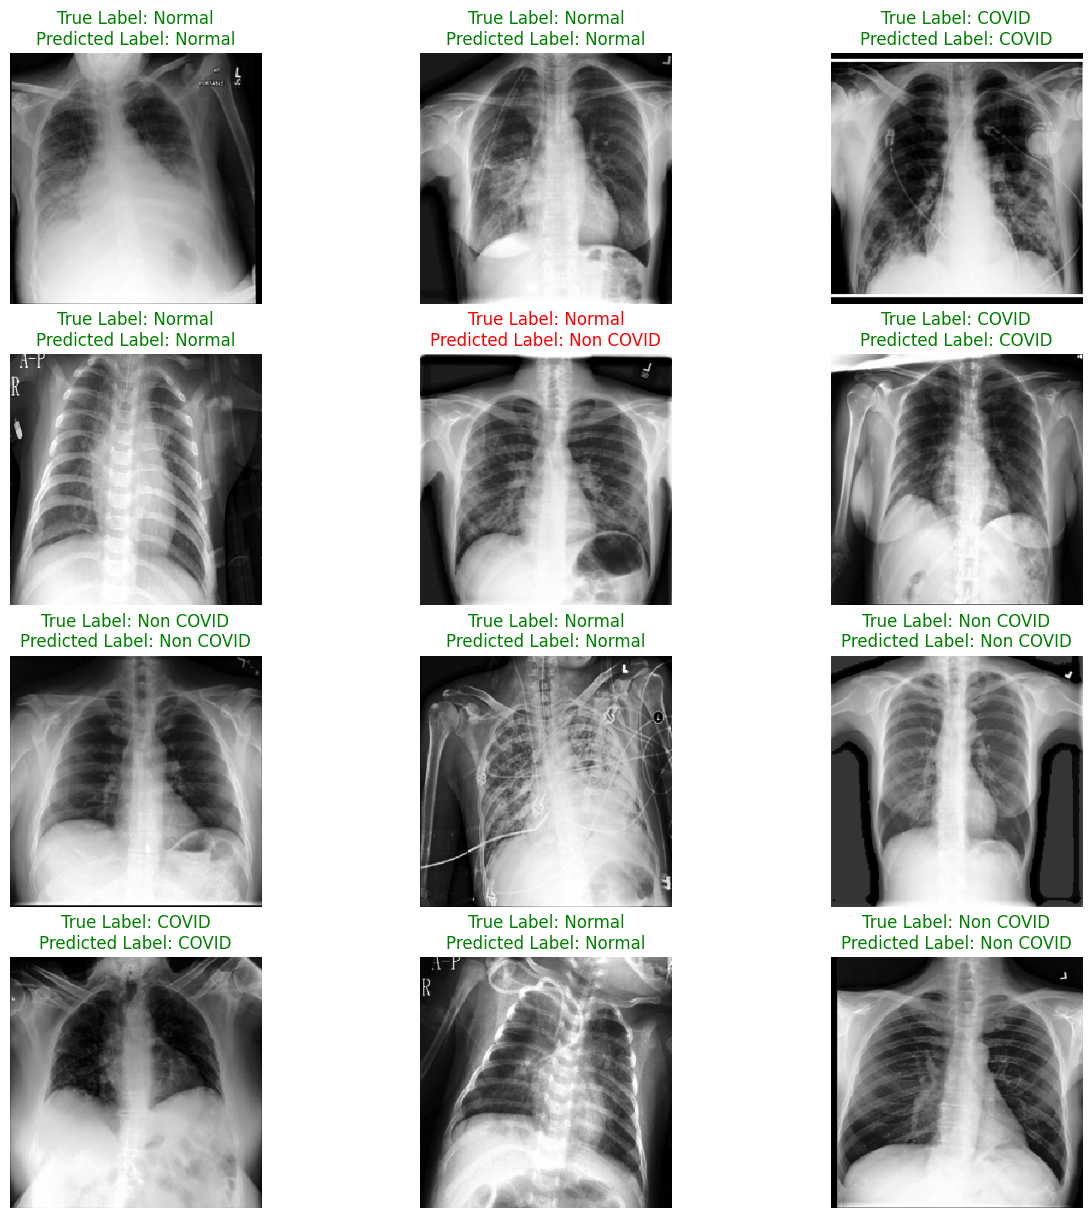

In [22]:
# Example usage for applying the model on multiple images from the test set
apply_model_and_visualize_multiple_images(XCeption_callbacks, test_generator)

In [27]:
XCeption_mask_callbacks = build_model()

In [28]:
# Model training - No early stopping as the fluctuation of val_loss is messing with it
history_Xception_mask_callbacks = XCeption_mask_callbacks.fit(train_generator_mask, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train_mask//batch_size,
                                validation_data=val_generator_mask,
                                validation_steps=nb_img_val_mask//batch_size,
                                callbacks = [reduce_learning_rate]
                                )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715856094.120107     154 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7475 - loss: 0.6229

W0000 00:00:1715856312.337547     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 271s 351ms/step - accuracy: 0.7476 - loss: 0.6227 - val_accuracy: 0.8532 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 2/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 3:17 291ms/step - accuracy: 0.7812 - loss: 0.5144

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 0.5144 - val_accuracy: 1.0000 - val_loss: 0.1687 - learning_rate: 0.0010
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 221s 325ms/step - accuracy: 0.8451 - loss: 0.4045 - val_accuracy: 0.8173 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.9688 - loss: 0.2119 - val_accuracy: 0.6667 - val_loss: 0.5552 - learning_rate: 0.0010
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8660 - loss: 0.3466
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
678/678 ━━━━━━━━━━━━━━━━━━━━ 221s 325ms/step - accuracy: 0.8660 - loss: 0.3466 - val_accuracy: 0.8560 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8438 - loss: 0.3372 - val_accuracy: 1.0000 - val_loss: 0.1082 - learning_rate: 1.0000e-04
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.9089 - loss:

In [31]:
evaluation_mask_callbacks = XCeption_mask_callbacks.evaluate(test_generator_mask)

# Print the evaluation metrics
print("Test Loss:", evaluation_mask_callbacks[0])
print("Test Accuracy:", evaluation_mask_callbacks[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - accuracy: 0.9004 - loss: 0.3926
Test Loss: 0.36898693442344666
Test Accuracy: 0.9029169082641602


  2/213 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step

W0000 00:00:1715858869.795887     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2395
           1       0.89      0.89      0.89      2140
           2       0.88      0.93      0.91      2253

    accuracy                           0.90      6788
   macro avg       0.90      0.90      0.90      6788
weighted avg       0.90      0.90      0.90      6788



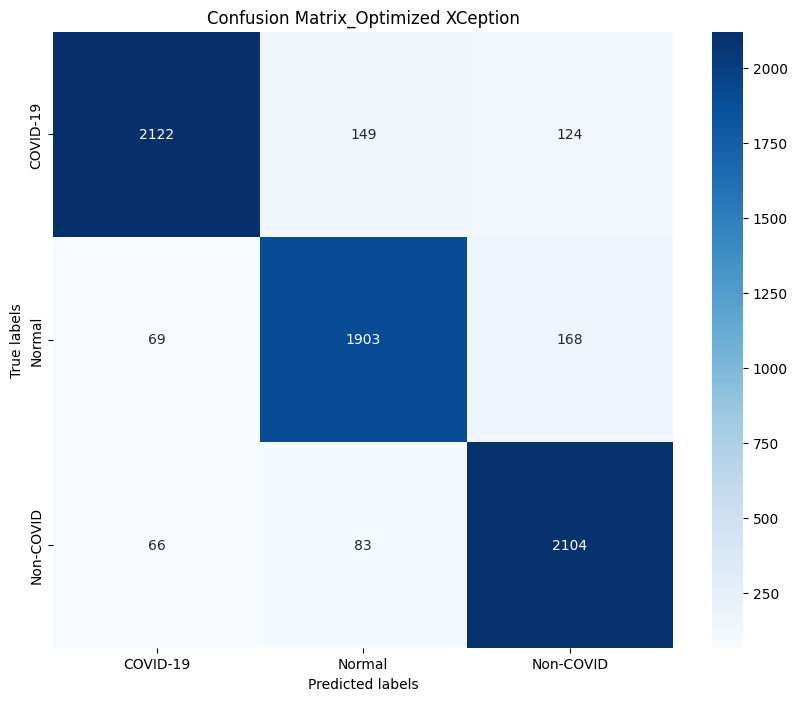

In [32]:
# Confusion_ matrix:
# Generate predictions on the test data
predictions_mask = XCeption_mask_callbacks.predict(test_generator_mask)
# Get the predicted classes
predicted_mask_classes = np.argmax(predictions_mask, axis=1)
# Get the true classes
true_mask_classes = test_generator_mask.classes

# Calculate the confusion matrix
conf_matrix_mask = confusion_matrix(true_mask_classes, predicted_mask_classes)
print(classification_report(true_mask_classes, predicted_mask_classes))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mask, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_mask.class_indices.keys(), yticklabels=test_generator_mask.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix_Optimized XCeption')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


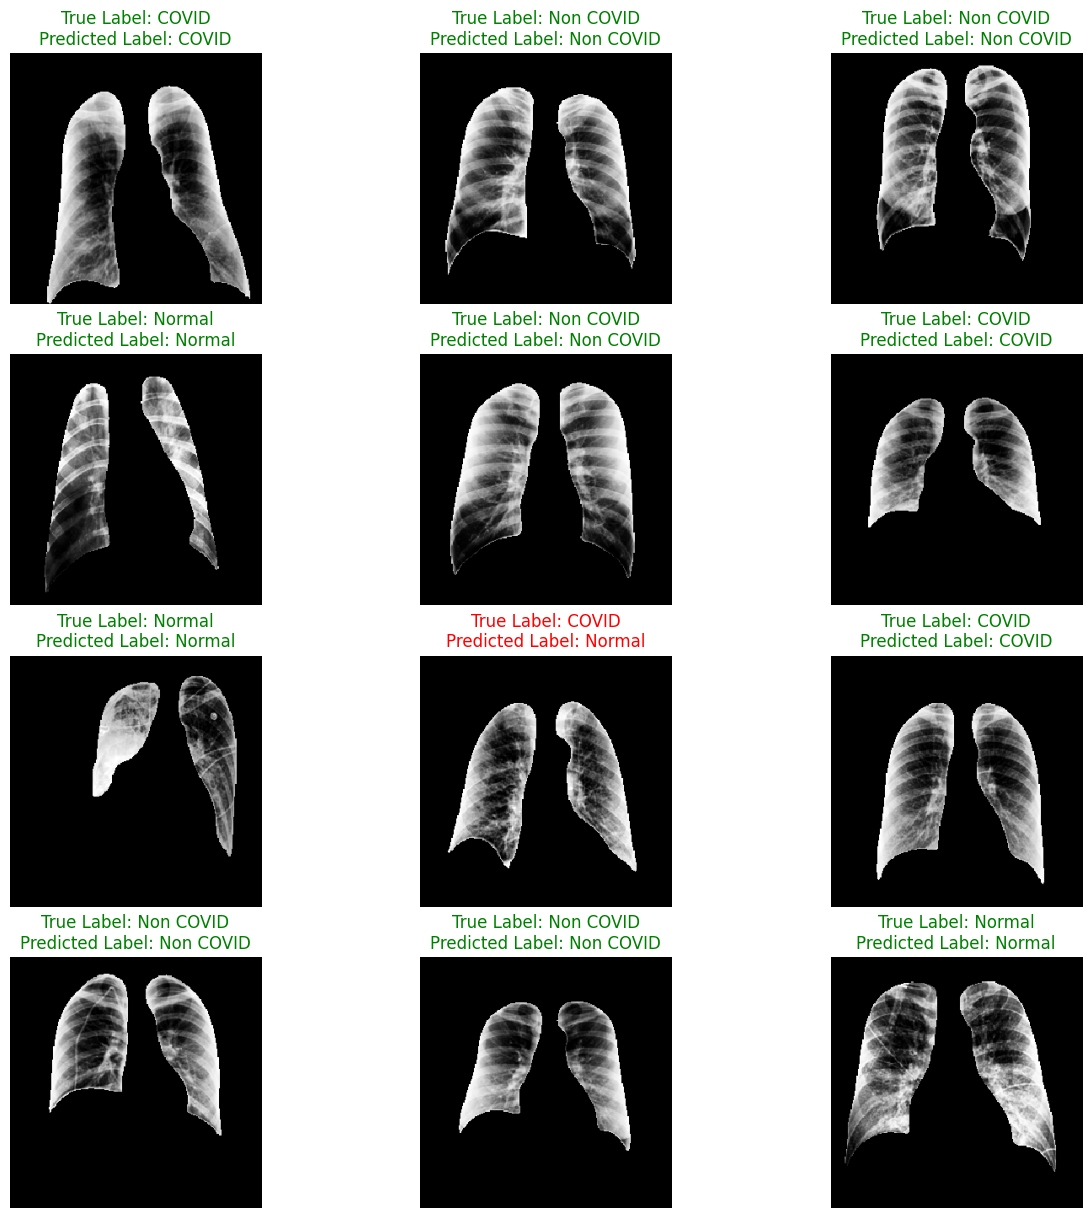

In [34]:
apply_model_and_visualize_multiple_images(XCeption_mask_callbacks, test_generator_mask)

GradCam

In [35]:
last_conv_layer_name = "block14_sepconv2_act"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(inputs = model.input, outputs = [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, alpha=0.005):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    plt.axis('off')
    plt.imshow(superimposed_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


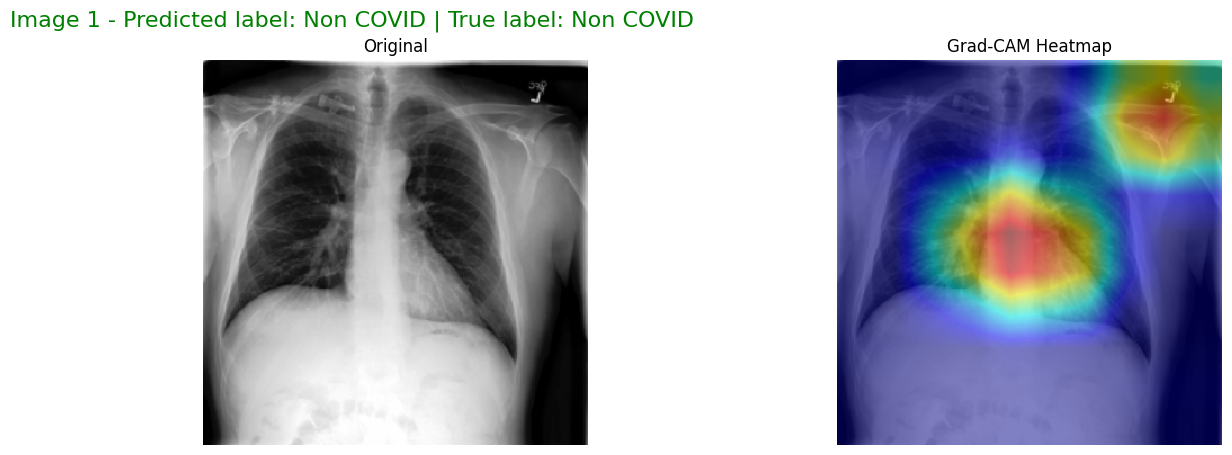

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


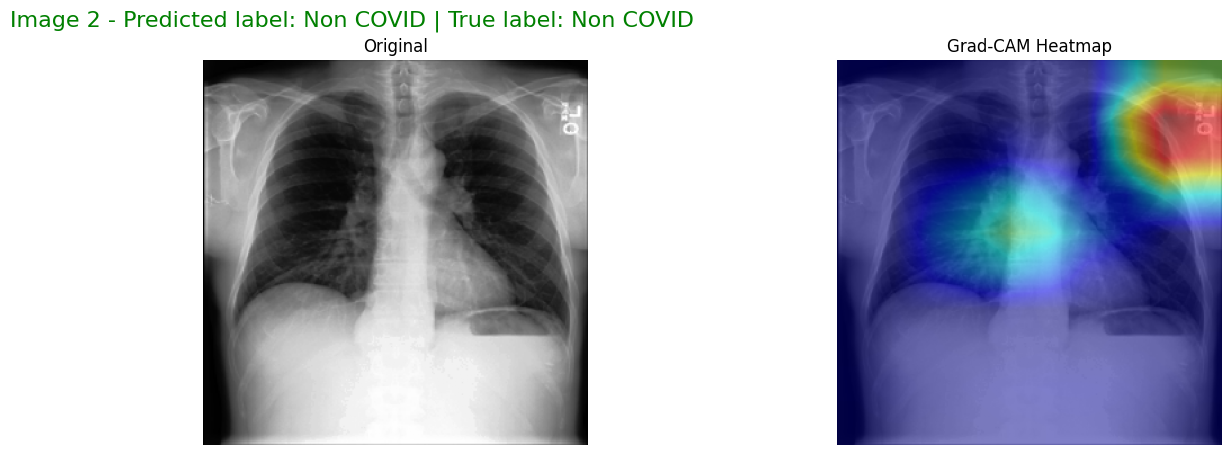

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


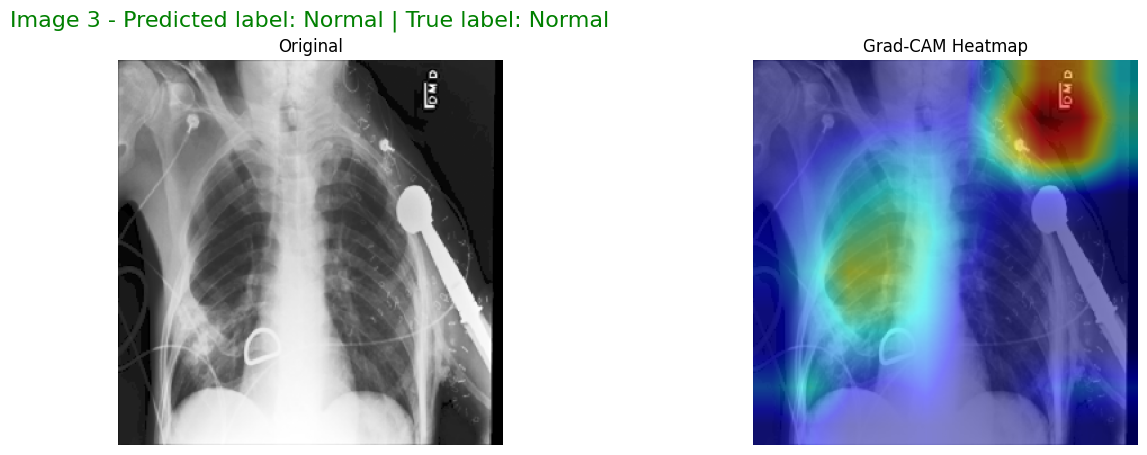

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


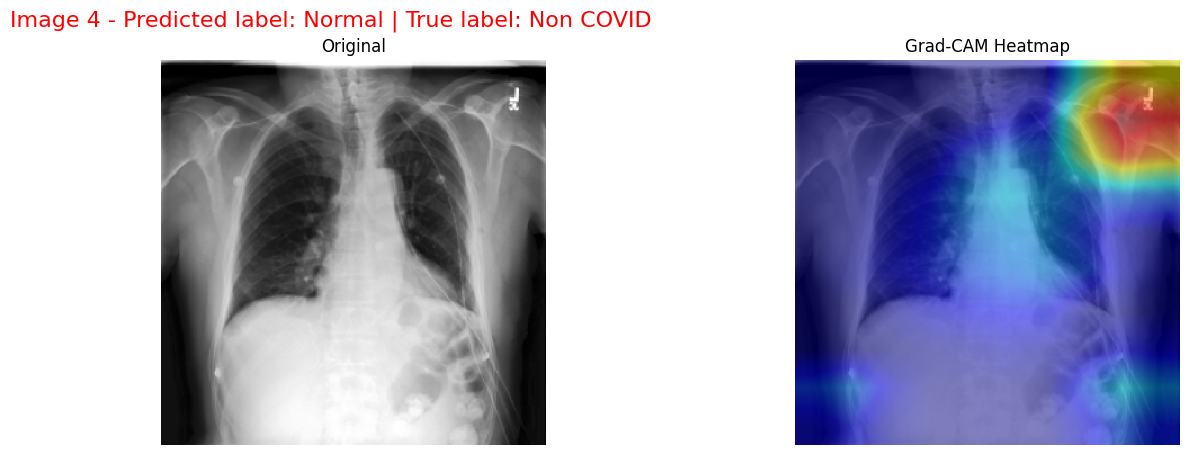

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


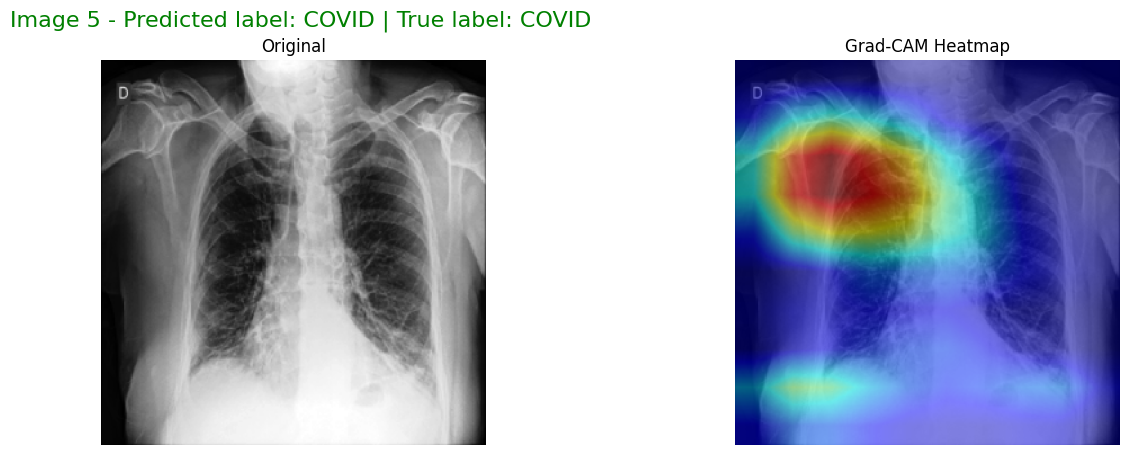

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


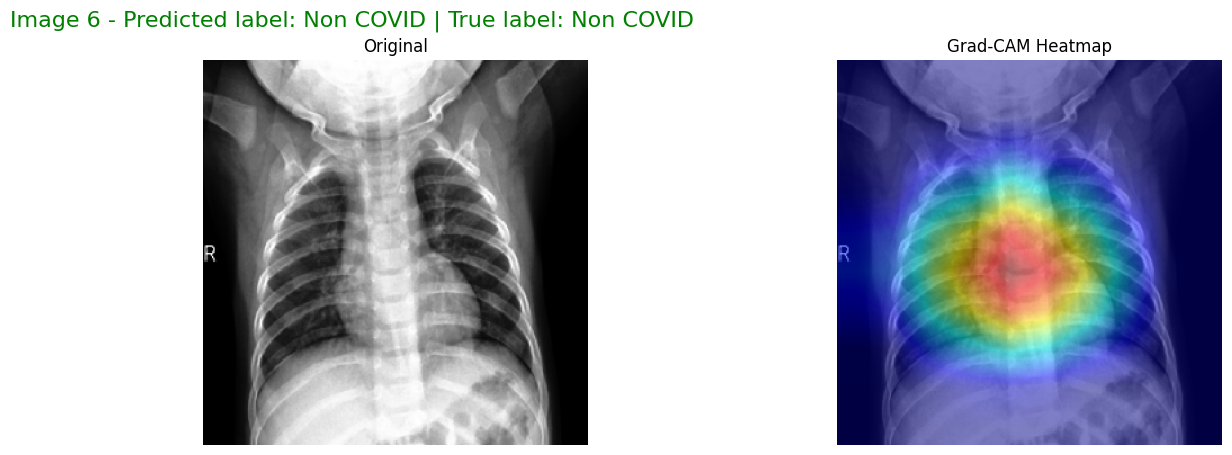

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


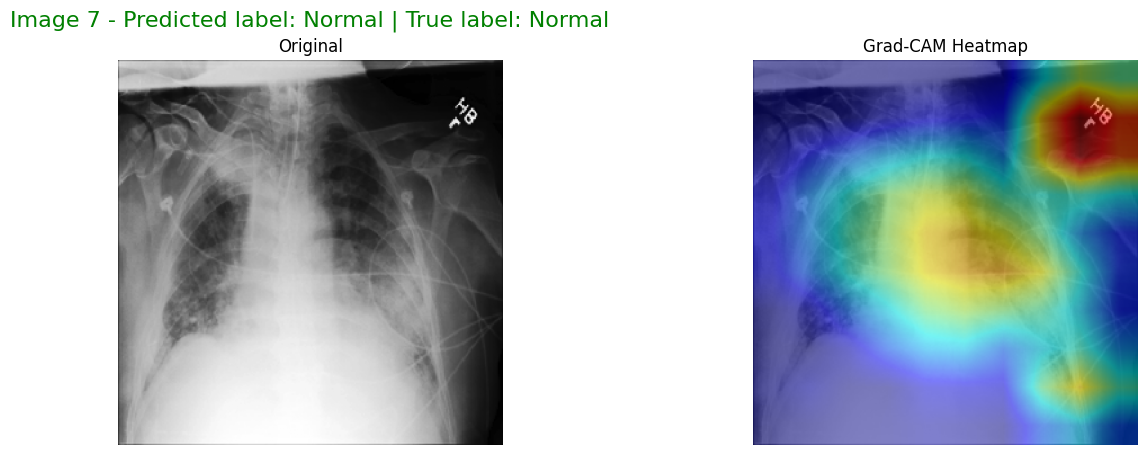

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


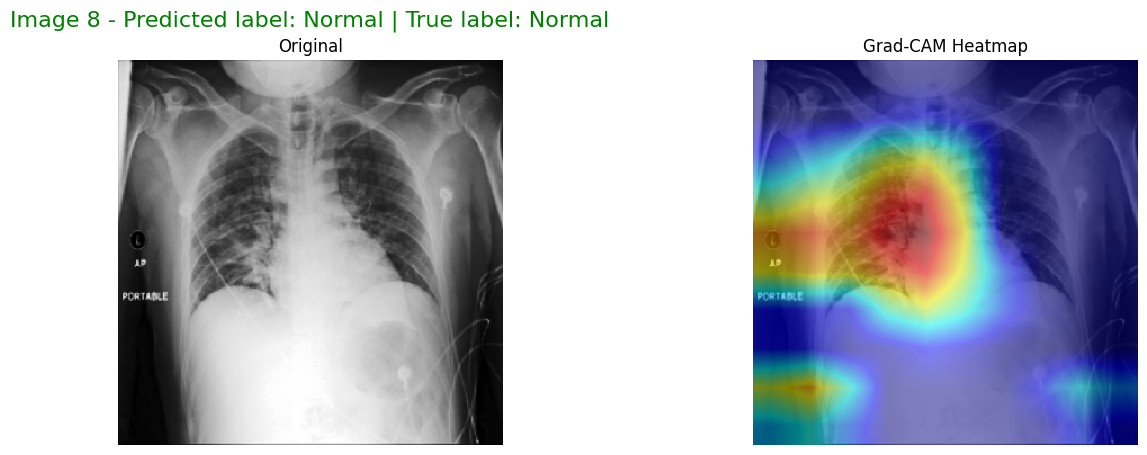

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


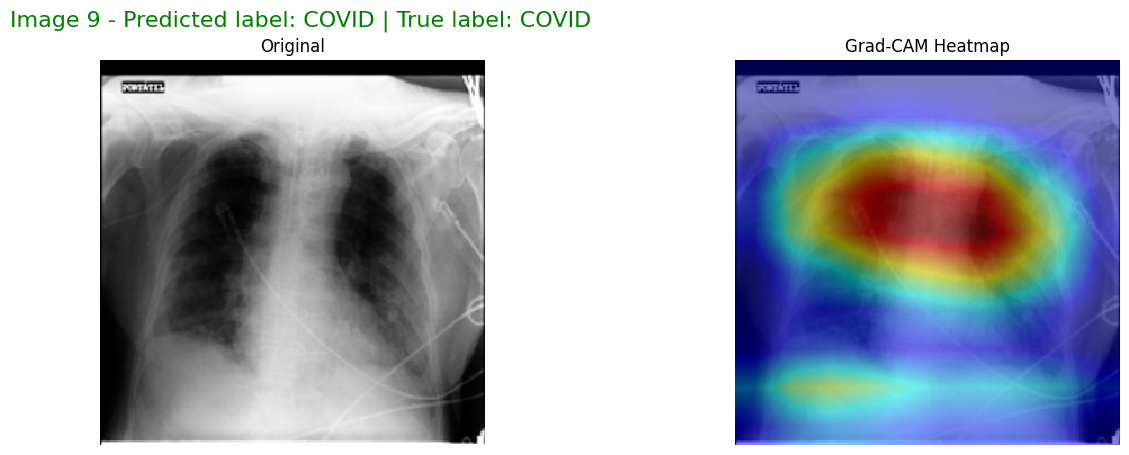

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


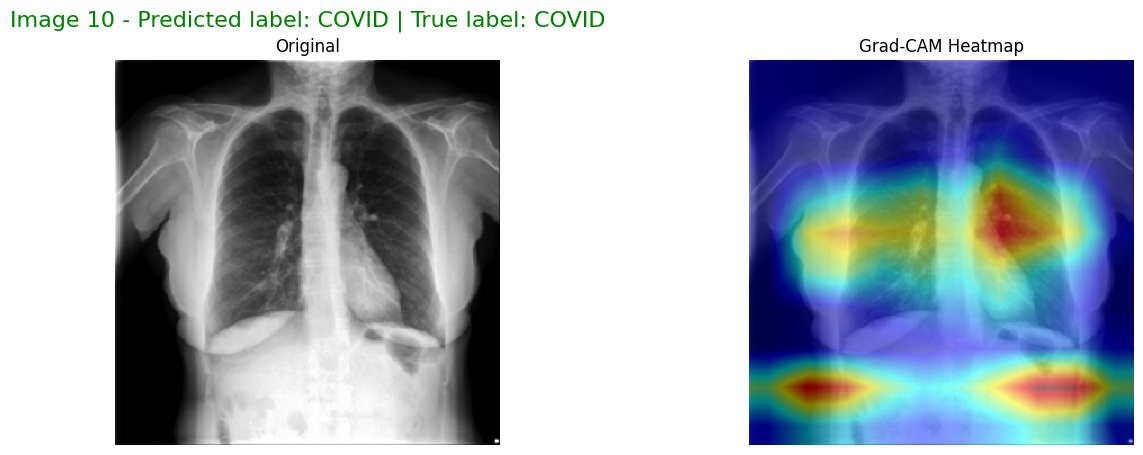

In [105]:
num_images_to_process = 10
model = XCeption_callbacks

model.layers[-1].activation = None

# Iterate through the images
for i in range(num_images_to_process):
    # Select images randomly
    batch_image, batch_label = random.choice(test_generator)
    image = batch_image[i] 
    image = np.expand_dims(image, axis=0)
    
    # Normalize the image for the superimposition (between 0 and 1)
    contrasted_image = (batch_image[i]+1)/2
    contrasted_image
    
    # Make the prediction
    prediction = model.predict(image)
    
    # Create the heatmap
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)
    
    # Resize the heatmap to the original image size
    heatmap = tf.expand_dims(heatmap, axis=-1)  # Add an extra channel dimension
    heatmap = tf.image.resize(heatmap, (contrasted_image.shape[0], contrasted_image.shape[1]))

    # Convert the heatmap to numpy array
    heatmap = heatmap.numpy()
    heatmap = np.abs(heatmap-1) # Red and blue are reversed, probably because cv2 and tensorflow dont use the same default colors - This will make them appear as I want

    # Normalize the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap (jet or any other)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert heatmap to float32 and scale to [0, 1]
    heatmap = heatmap.astype(np.float32) / 255
    
    # Superimpose both images
    superimposed_img = cv2.addWeighted(contrasted_image, 0.5, heatmap, 0.5, 0)
    
    # Get predicted and true labels
    true_label = batch_label[i]
    true_class_name = class_names[true_label]
    predicted_label = np.argmax(prediction[0])
    predicted_class_name = class_names[predicted_label]
    
    title_color = 'green' if true_label == predicted_label else 'red'
    
    # Plot the original image and the Grad-CAM heatmap
    plt.figure(figsize=(15, 5))
    plt.suptitle('Image {} - Predicted label: {} | True label: {}'.format(i+1, predicted_class_name, true_class_name), fontsize=16, x=0.5, y=0.98, horizontalalignment='right', color=title_color)
    plt.subplot(1, 2, 1)
    plt.imshow(contrasted_image)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()
    
    # Heatmap colors are reversed, will stay as it is for now since it works

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


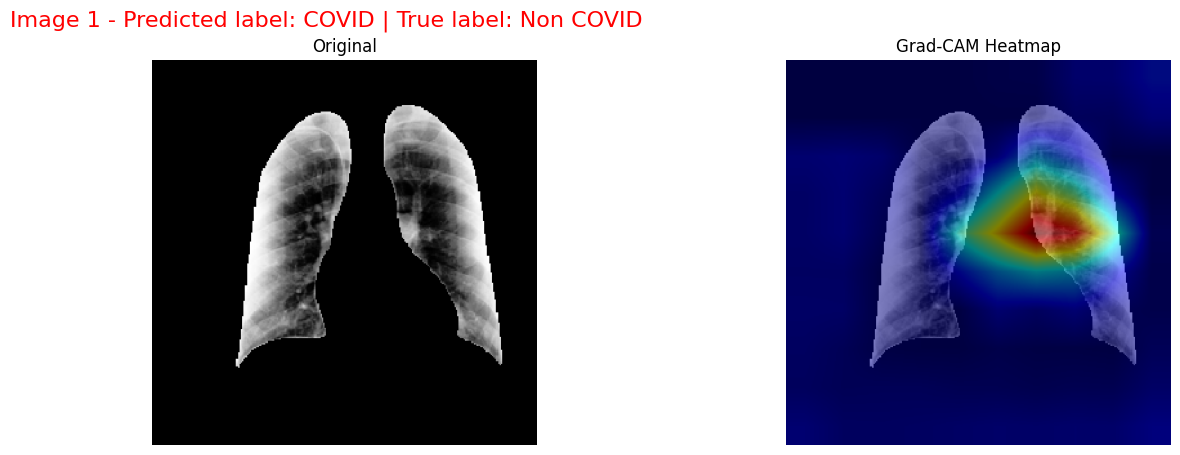

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


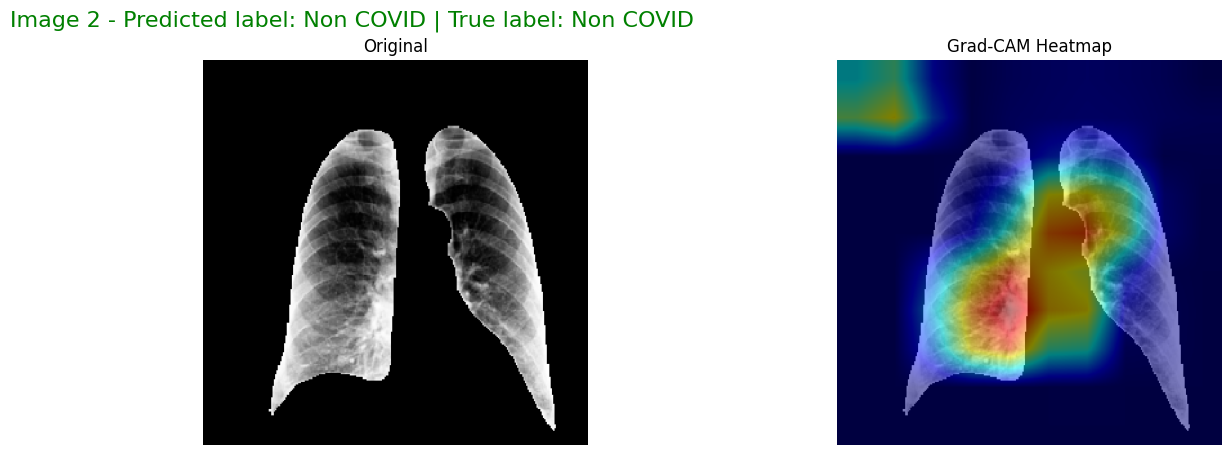

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


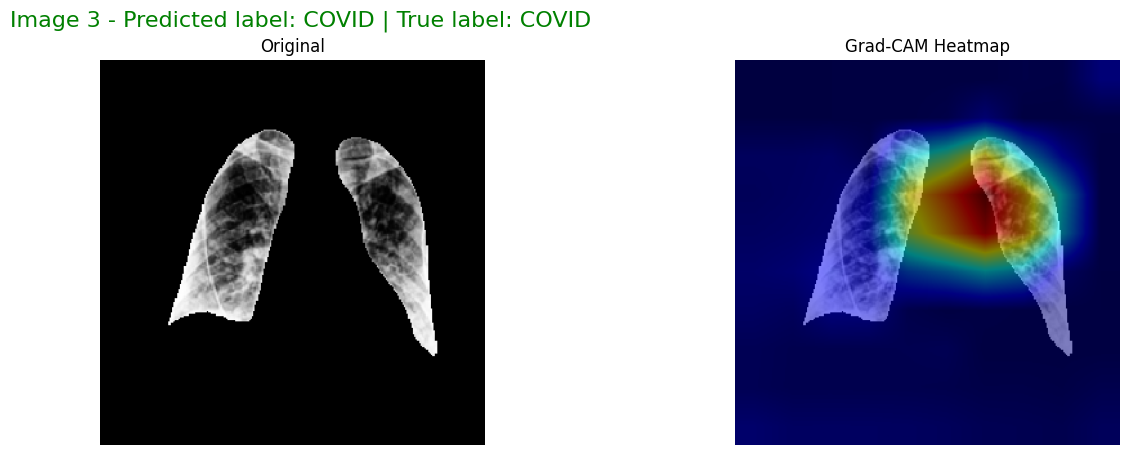

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


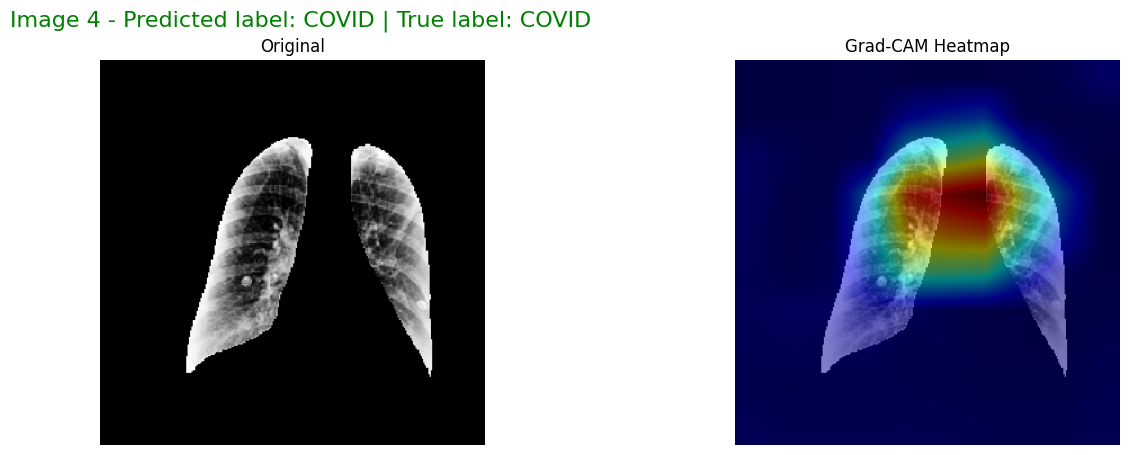

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


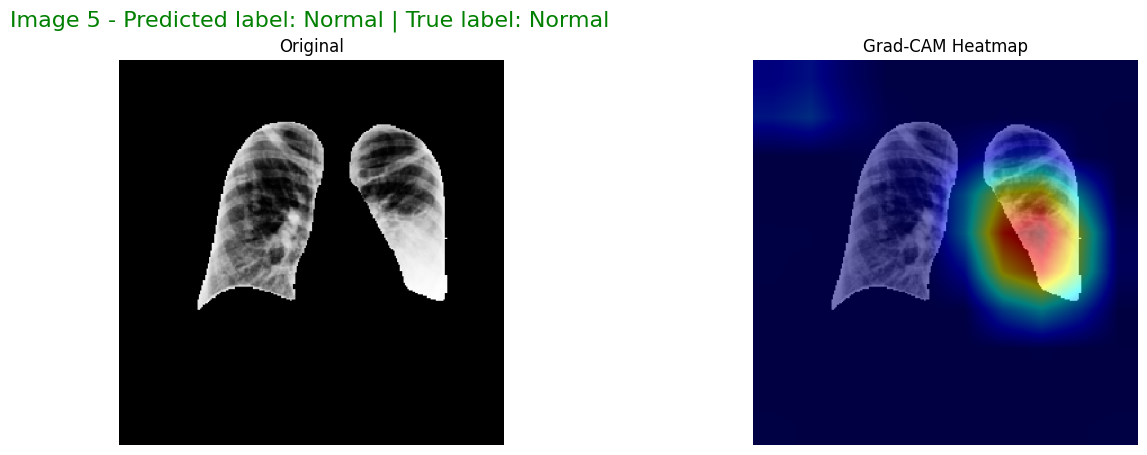

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


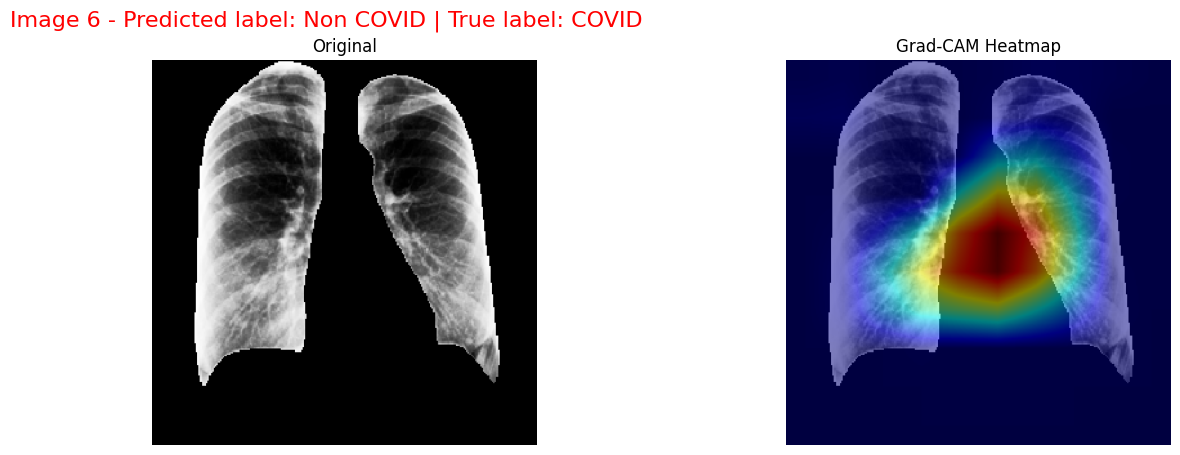

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


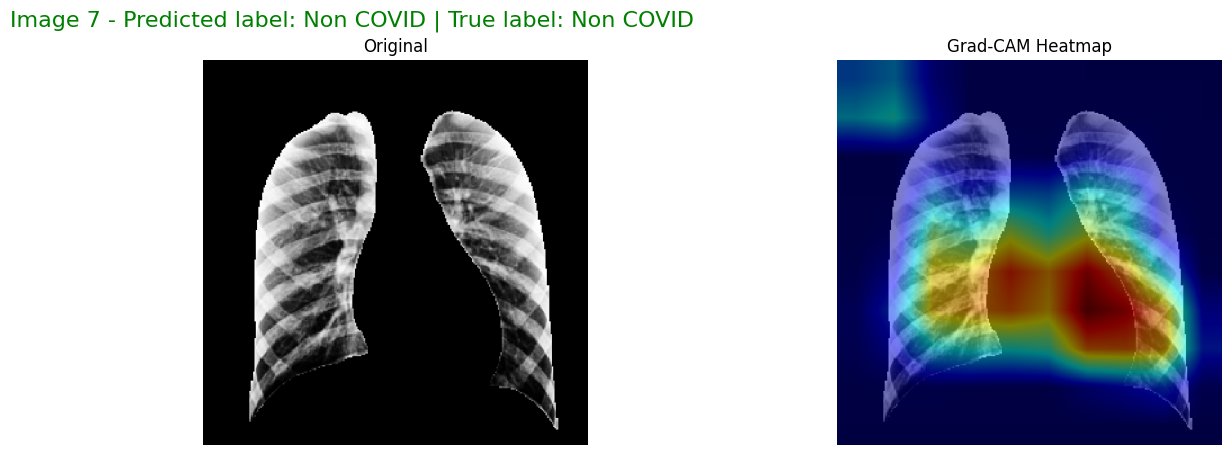

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


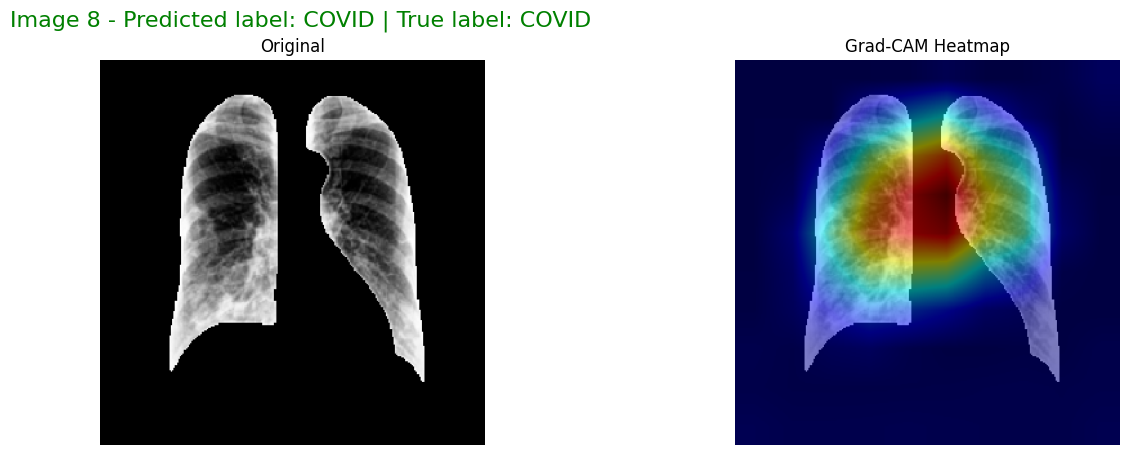

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


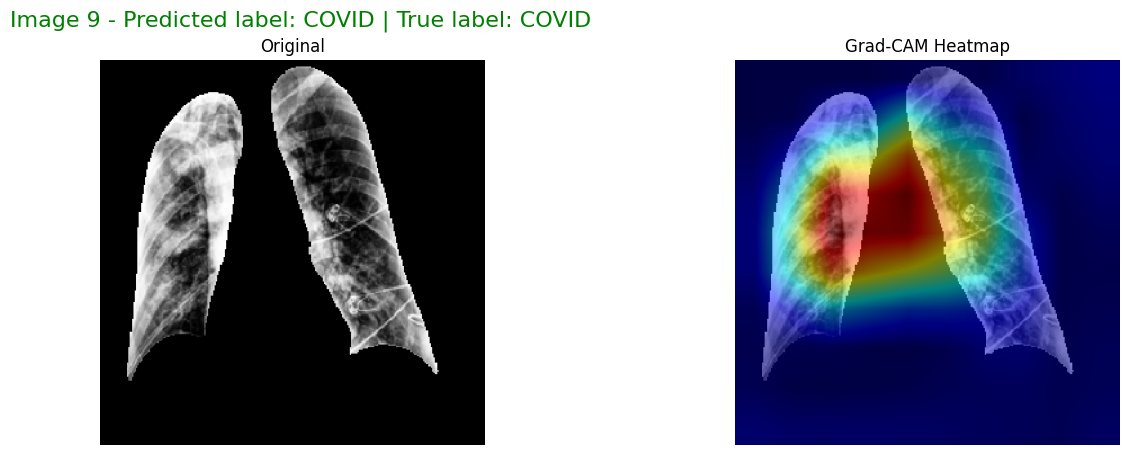

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


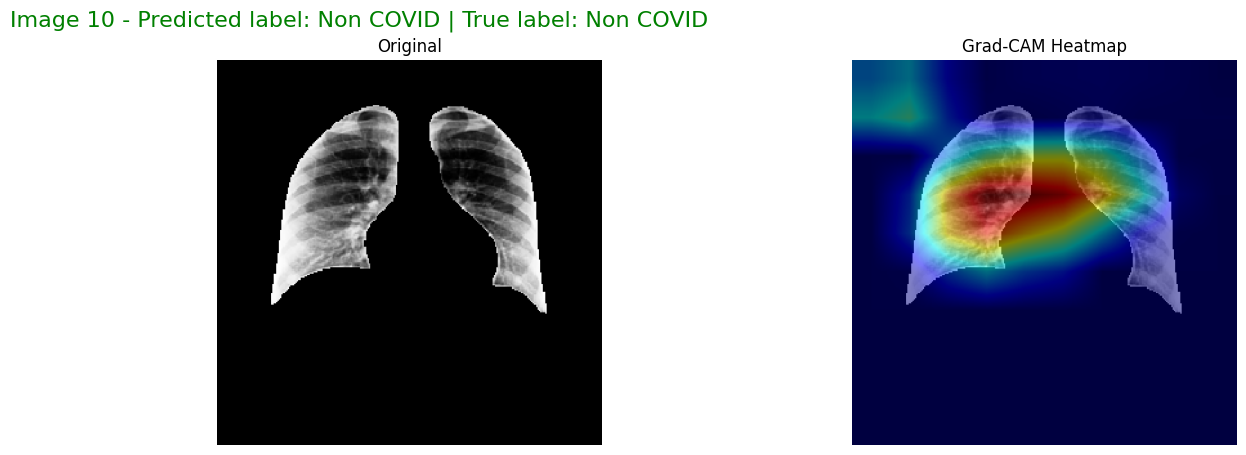

In [106]:
model_mask = XCeption_mask_callbacks

model_mask.layers[-1].activation = None

# Iterate through the images
for i in range(num_images_to_process):
    # Select images randomly
    batch_image_mask, batch_label_mask = random.choice(test_generator_mask)
    image_mask = batch_image_mask[i] 
    image_mask = np.expand_dims(image_mask, axis=0)
    
    # Normalize the image for the superimposition (between 0 and 1)
    contrasted_image_mask = (batch_image_mask[i]+1)/2
    contrasted_image_mask
    
    # Make the prediction
    prediction_mask = model_mask.predict(image_mask)
    
    # Create the heatmap
    heatmap_mask = make_gradcam_heatmap(image_mask, model_mask, last_conv_layer_name)
    
    # Resize the heatmap to the original image size
    heatmap_mask = tf.expand_dims(heatmap_mask, axis=-1)  # Add an extra channel dimension
    heatmap_mask = tf.image.resize(heatmap_mask, (contrasted_image_mask.shape[0], contrasted_image_mask.shape[1]))

    # Convert the heatmap to numpy array
    heatmap_mask = heatmap_mask.numpy()
    heatmap_mask = np.abs(heatmap_mask-1) # Red and blue are reversed, probably because cv2 and tensorflow dont use the same default colors - This will make them appear as I want

    # Normalize the heatmap
    heatmap_mask = np.uint8(255 * heatmap_mask)

    # Apply colormap (jet or any other)
    heatmap_mask = cv2.applyColorMap(heatmap_mask, cv2.COLORMAP_JET)

    # Convert heatmap to float32 and scale to [0, 1]
    heatmap_mask = heatmap_mask.astype(np.float32) / 255
    
    # Superimpose both images
    superimposed_img_mask = cv2.addWeighted(contrasted_image_mask, 0.5, heatmap_mask, 0.5, 0)
    
    # Get predicted and true labels
    true_label_mask = batch_label_mask[i]
    true_class_name_mask = class_names[true_label_mask]
    predicted_label_mask = np.argmax(prediction_mask[0])
    predicted_class_name_mask = class_names[predicted_label_mask]
    
    title_color = 'green' if true_label_mask == predicted_label_mask else 'red'
    
    # Plot the original image and the Grad-CAM heatmap
    plt.figure(figsize=(15, 5))
    plt.suptitle('Image {} - Predicted label: {} | True label: {}'.format(i+1, predicted_class_name_mask, true_class_name_mask), fontsize=16, x=0.5, y=0.98, horizontalalignment='right', color=title_color)
    plt.subplot(1, 2, 1)
    plt.imshow(contrasted_image_mask)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img_mask)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()
    
    # Heatmap colors are reversed, will stay as it is for now since it works